In [1]:
import pandas as pd
pd.options.display.max_columns = None
import numpy as np
import pickle
import shap
from sklearn.metrics import plot_confusion_matrix, accuracy_score, roc_auc_score

shap.initjs()

shap_plots_path = 'Shap_plots'
all_or_part = 'partFeatures'

### Utils

In [2]:
def test_estimator(estimator, X_test, y_test):

    y_pred = estimator.predict(X_test)
    print("Accuracy test: ", accuracy_score(y_test, y_pred))
    print("AUC test: ", roc_auc_score(y_test, y_pred))

    plot_confusion_matrix(estimator, X_test, y_test)

### Wczytanie zbioru

In [3]:
df = pd.read_csv('../../our_data/Etap5/Etap3/all_for_FI_without_outliers.csv')
scaler = pickle.load(open("../Etap5/scaler_without_outliers.pkl", 'rb'))

del df['video_id']
df = df.fillna(-1)
print(df.shape)
df[:3]

(15445, 54)


,category_id,views,likes,dislikes,comment_count,pub_day_of_the_week,pub_day,pub_hour,dislikes/likes,likes/views,dislikes/views,comment_count/views,n_of_tags,title_length,title_n_of_words,title_capital_letters,title_capital_letters_percent,title_small_letters,title_small_letters_percent,title_punctuation,title_punctuation_percent,title_n_of_emojis,desc_length,desc_n_of_words,desc_capital_letters,desc_capital_letters_percent,desc_small_letters,desc_small_letters_percent,desc_punctuation,desc_punctuation_percent,desc_n_of_urls,desc_n_of_emojis,isFacebook,isTwitter,isInstagram,mean_h,mean_s,mean_v,std_h,std_s,std_v,entropy,avg_texts_coordX,avg_texts_coordY,ocr_sentiment_compound,Sad,Fear,Angry,Happy,Neutral,Surprise,people,faces,trending
0,10,3.156279,6.860132,0.530014,3.044567,-1.478162,0.920080,0.222228,-0.247672,0.239150,-0.061108,-0.022347,-0.981476,0.292420,-0.547389,-0.036612,-0.208537,-0.621686,-1.139866,4.644111,4.195544,-0.097413,-1.003053,-0.898497,-0.593204,1.505147,-1.029948,-1.452863,-0.614837,0.741770,-0.896669,-0.243586,0,0,0,-0.605053,-1.482737,0.972724,-0.219746,-1.423649,0.201933,-0.070243,-1.193143,-1.434435,-0.115615,-0.441187,-0.289289,-0.403271,-0.556994,-0.480048,-0.116932,0.939693,-0.781259,0
1,10,2.701422,7.622910,0.180755,4.367196,0.151210,-1.659686,0.222228,-0.253289,0.490361,-0.062387,-0.022341,2.076977,-1.566546,-1.388068,-0.748343,-0.067582,-1.470444,-1.144482,-0.637835,0.191015,-0.097413,-0.925557,-0.926032,-0.642138,-0.586878,-0.926245,0.074061,-0.730161,2.640549,-0.356408,-0.243586,1,0,1,0.299640,-1.045710,0.476901,0.229982,-0.763544,-0.607451,-0.143248,-1.193143,-1.434435,-0.115615,-0.441187,-0.289289,-0.403271,-0.556994,1.142347,-0.116932,-0.452174,-0.246892,0
2,10,-0.178126,-0.392521,-0.443310,-0.437885,0.694334,-0.487065,-1.438592,-0.213505,-0.507029,-0.062269,-0.022353,-0.498563,0.744601,-0.547389,-0.273855,-0.519735,0.945252,0.522113,3.059527,2.185463,-0.097413,-0.910796,-0.806716,-0.560581,0.417990,-0.915134,-0.030460,-0.730161,-0.403498,-0.761604,0.673798,0,0,0,1.204014,2.172123,0.680729,-0.566376,1.549637,0.235831,0.531390,1.614983,0.332041,1.507315,-0.441187,-0.289289,-0.403271,-0.556994,-0.480048,-0.116932,-0.591361,-0.781259,0


### Dzielenie zbioru

In [4]:
from sklearn.model_selection import train_test_split
# for col in df.columns:
#     temp = df[col].isna()
#     print(f"{col}:, {temp.any()} {temp.sum()}")

X_train, X_test, y_train, y_test = train_test_split(df.loc[:,~df.columns.isin(['trending'])],
#                                                     df.loc[:,columns_to_use],
                                                    df['trending'], 
                                                    test_size=0.3,
                                                    random_state=42,
                                                    stratify=df['category_id']
                                                   )

print(f'X_train: ', X_train.shape)
print(f'y_train: ', y_train.shape)
print(f'X_test: ', X_test.shape)
print(f'y_test: ', y_test.shape)

# Do Shapa
sample_test_set = shap.sample(pd.concat([X_test,y_test],axis=1), 8000)
sample_train_set = shap.sample(X_train, 150) 

columns_not_to_standarize = [
    'video_id', 'category_id', 'trending',
    'isFacebook', 'isTwitter', 'isInstagram'
]

sample_test_set_not_standarized = sample_test_set.copy()
sample_test_set_not_standarized.loc[:, sample_test_set_not_standarized.columns.difference(columns_not_to_standarize)] = scaler.inverse_transform(sample_test_set_not_standarized.loc[:, sample_test_set_not_standarized.columns.difference(columns_not_to_standarize)].values)
sample_test_set_not_standarized[:3]

X_train:  (10811, 53)
y_train:  (10811,)
X_test:  (4634, 53)
y_test:  (4634,)


,category_id,views,likes,dislikes,comment_count,pub_day_of_the_week,pub_day,pub_hour,dislikes/likes,likes/views,dislikes/views,comment_count/views,n_of_tags,title_length,title_n_of_words,title_capital_letters,title_capital_letters_percent,title_small_letters,title_small_letters_percent,title_punctuation,title_punctuation_percent,title_n_of_emojis,desc_length,desc_n_of_words,desc_capital_letters,desc_capital_letters_percent,desc_small_letters,desc_small_letters_percent,desc_punctuation,desc_punctuation_percent,desc_n_of_urls,desc_n_of_emojis,isFacebook,isTwitter,isInstagram,mean_h,mean_s,mean_v,std_h,std_s,std_v,entropy,avg_texts_coordX,avg_texts_coordY,ocr_sentiment_compound,Sad,Fear,Angry,Happy,Neutral,Surprise,people,faces,trending
11925,28,165223.0,2452.0,265.0,1.0,2.0,9.0,6.0,0.108075,0.014841,0.001604,0.000006,30.0,47.0,7.0,6.0,0.127660,27.0,0.574468,5.0,0.106383,1.734723e-17,776.0,123.0,65.0,0.083763,525.0,0.676546,18.0,0.048969,4.0,5.551115e-17,0,0,0,0.228885,0.124931,0.580314,0.305953,0.216951,0.420357,5.926161,109.833333,190.833333,6.938894e-18,5.551115e-17,1.387779e-17,0.0,0.0,0.0,0.0,89.0,0.0,1
768,24,7187.0,72.0,1.0,1.0,4.0,6.0,4.0,0.013889,0.010018,0.000139,0.000139,0.0,24.0,4.0,14.0,0.583333,1.0,0.041667,1.0,0.041667,1.734723e-17,17.0,3.0,2.0,0.117647,0.0,0.000000,1.0,0.058824,0.0,5.551115e-17,0,0,0,0.211116,0.121069,0.415276,0.191660,0.217380,0.418833,5.292400,217.000000,106.000000,6.938894e-18,5.551115e-17,1.387779e-17,0.0,1.0,0.0,0.0,4.0,1.0,0
4931,25,209951.0,1513.0,68.0,223.0,3.0,25.0,13.0,0.044944,0.007206,0.000324,0.001062,27.0,98.0,17.0,22.0,0.224490,56.0,0.571429,2.0,0.020408,1.734723e-17,1277.0,172.0,179.0,0.140172,827.0,0.647612,30.0,0.060298,8.0,5.551115e-17,0,0,0,0.446859,0.350695,0.583564,0.346788,0.325867,0.391406,6.720005,76.000000,289.000000,6.938894e-18,5.551115e-17,1.387779e-17,0.0,0.0,1.0,0.0,1.0,1.0,0


# Bez oczywistych atrybutów *likes*, *views* ...

In [5]:
columns_to_use = [
    'category_id',
#  'views',
#  'likes',
#  'dislikes',
#  'comment_count',
 'pub_day_of_the_week',
 'pub_day',
 'pub_hour',
#  'dislikes/likes',
#  'likes/views',
#  'dislikes/views',
#  'comment_count/views',
 'n_of_tags',
 'title_length',
 'title_n_of_words',
 'title_capital_letters',
 'title_capital_letters_percent',
 'title_small_letters',
 'title_small_letters_percent',
 'title_punctuation',
 'title_punctuation_percent',
 'title_n_of_emojis',
 'desc_length',
 'desc_n_of_words',
 'desc_capital_letters',
 'desc_capital_letters_percent',
 'desc_small_letters',
 'desc_small_letters_percent',
 'desc_punctuation',
 'desc_punctuation_percent',
 'desc_n_of_urls',
 'desc_n_of_emojis',
 'isFacebook',
 'isTwitter',
 'isInstagram',
 'mean_h',
 'mean_s',
 'mean_v',
 'std_h',
 'std_s',
 'std_v',
 'entropy',
 'avg_texts_coordX',
 'avg_texts_coordY',
 'ocr_sentiment_compound',
 'Sad',
 'Fear',
 'Angry',
 'Happy',
 'Neutral',
 'Surprise',
 'people',
 'faces',
 'trending'
]

### Wybranie kolumn

In [6]:
## Wybranie kolumn
X_train = X_train.loc[:,columns_to_use[:-1]]
X_test = X_test.loc[:,columns_to_use[:-1]]
sample_test_set_not_standarized = sample_test_set_not_standarized.loc[:,columns_to_use]
sample_train_set = sample_train_set.loc[:,columns_to_use[:-1]]
sample_test_set = sample_test_set.loc[:,columns_to_use]


print(f'X_train: ', X_train.shape)
print(f'y_train: ', y_train.shape)
print(f'sample_test_set_not_standarized: ', sample_test_set_not_standarized.shape)
print(f'sample_train_set: ', sample_train_set.shape)
print(f'sample_test_set: ', sample_test_set.shape)

X_train:  (10811, 45)
y_train:  (10811,)
sample_test_set_not_standarized:  (4634, 46)
sample_train_set:  (150, 45)
sample_test_set:  (4634, 46)


In [7]:
best_each_classifier = pickle.load(open(f'./results_stratified_{all_or_part}.pkl', 'rb'))

## LogisticRegression - bez standaryzacji

TRAIN
Accuracy mean: LogisticRegression(n_jobs=-1, solver='liblinear')
Accuracy mean: 0.6347243588345409
Accuracy std: 0.008044951809024484
AUC mean: 0.6840390465206864
AUC std: 0.01302733877508168
TEST
Accuracy test:  0.5384117393180837
AUC test:  0.5363513867085296


,coef
desc_punctuation_percent,62.949003
desc_small_letters_percent,1.567071
mean_h,1.435046
isTwitter,1.230582
std_v,1.191986
title_n_of_emojis,1.115722
desc_n_of_urls,1.113771
entropy,1.059296
Sad,1.055572
Happy,1.023196


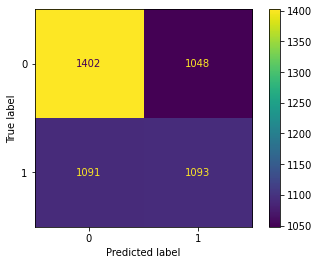

In [8]:
# Interpretacja LR - https://towardsdatascience.com/black-box-models-are-actually-more-explainable-than-a-logistic-regression-f263c22795d

print("TRAIN")
print(f"Accuracy mean: { best_each_classifier['LogisticRegressionNotStandarized']['estimator']['clf']}")
print(f"Accuracy mean: {best_each_classifier['LogisticRegressionNotStandarized']['mean_accuracy']}")
print(f"Accuracy std: {best_each_classifier['LogisticRegressionNotStandarized']['std_accuracy']}")
print(f"AUC mean: {best_each_classifier['LogisticRegressionNotStandarized']['mean_AUC']}")
print(f"AUC std: {best_each_classifier['LogisticRegressionNotStandarized']['std_AUC']}")

print("TEST")
estimator = best_each_classifier['LogisticRegressionNotStandarized']['estimator']['clf']
test_estimator(estimator, X_test, y_test)

log_odds_scaled = np.exp(estimator.coef_[0])

pd.DataFrame(log_odds_scaled, 
             X_test.columns, 
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)

## LogisticRegression - standaryzacja SHAP

TRAIN
Accuracy mean: LogisticRegression(C=10.0, n_jobs=-1, solver='liblinear')
Accuracy mean: 0.629636862154398
Accuracy std: 0.008417678364039066
AUC mean: 0.6820581804169656
AUC std: 0.013468971235971305
TEST
Accuracy test:  0.6422097539922313
AUC test:  0.6405298273155416


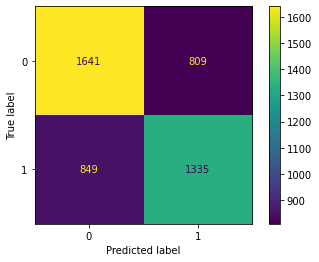

In [9]:
print("TRAIN")
print(f"Accuracy mean: { best_each_classifier['LogisticRegression']['estimator']['clf']}")
print(f"Accuracy mean: {best_each_classifier['LogisticRegression']['mean_accuracy']}")
print(f"Accuracy std: {best_each_classifier['LogisticRegression']['std_accuracy']}")
print(f"AUC mean: {best_each_classifier['LogisticRegression']['mean_AUC']}")
print(f"AUC std: {best_each_classifier['LogisticRegression']['std_AUC']}")

estimator = best_each_classifier['LogisticRegression']['estimator']['clf']
print("TEST")
test_estimator(estimator, X_test, y_test)

In [10]:
class_id = 1
explainer_LR_ALL = pickle.load(open(f'./{shap_plots_path}/LogisticRegression_{all_or_part}/explainer_LR_stratified_{all_or_part}.pkl', 'rb'))
shap_values_LR_ALL = pickle.load(open(f'./{shap_plots_path}/LogisticRegression_{all_or_part}/shap_values_LR_stratified_{all_or_part}.pkl', 'rb'))

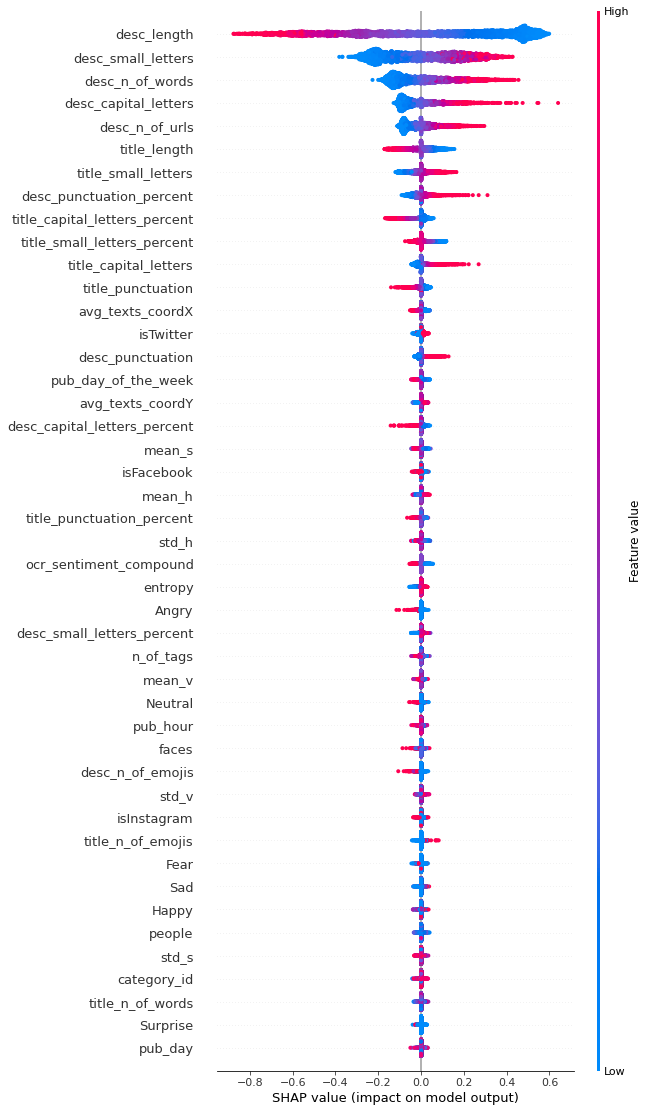

In [11]:
shap.summary_plot(shap_values_LR_ALL[class_id], sample_test_set_not_standarized.iloc[:, :-1], X_test.columns, max_display=60)

In [12]:
sample_id = 10

shap.force_plot(
    explainer_LR_ALL.expected_value[class_id],
    shap_values_LR_ALL[class_id][sample_id,:],
    sample_test_set_not_standarized.iloc[sample_id:sample_id+1, :-1],
    X_test.columns,
)

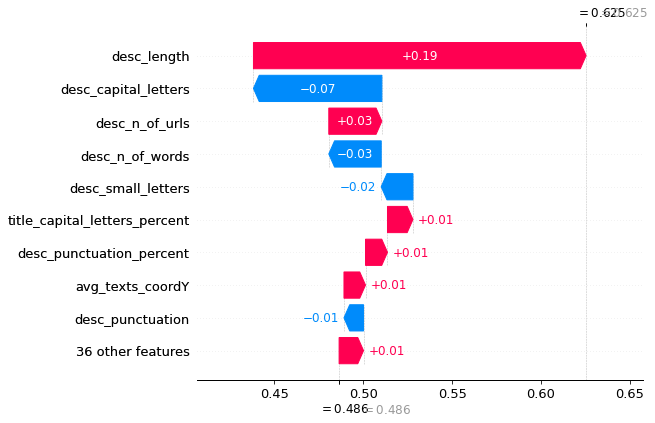

In [13]:
shap.plots._waterfall.waterfall_legacy(explainer_LR_ALL.expected_value[class_id], 
                                       shap_values_LR_ALL[class_id][sample_id], 
                                       feature_names=X_test.columns)

In [14]:
# shap.force_plot(
#     explainer_LR_ALL.expected_value[class_id],
#     shap_values_LR_ALL[class_id],
#     sample_test_set_not_standarized.iloc[:, :-1],
# )

In [15]:
# save_dependency_plots(shap_values=shap_values_LR_ALL,
#                       clf_name='LogisticRegression_AllFeatures',
#                       sample_test_set_not_standarized=sample_test_set_not_standarized.iloc[:, :-1])     

## RandomForestClassifier - SHAP

TRAIN
Accuracy mean: RandomForestClassifier(criterion='entropy', n_jobs=-1)
Accuracy mean: 0.6916101809808645
Accuracy std: 0.009662023256920655
AUC mean: 0.7685200555376879
AUC std: 0.012421135603061163
TEST
Accuracy test:  0.7075960293482952
AUC test:  0.7076360544217688


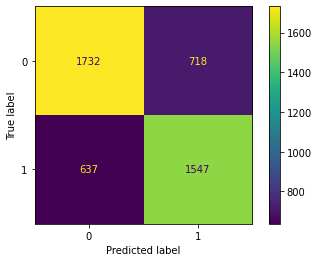

In [16]:
print("TRAIN")
print(f"Accuracy mean: { best_each_classifier['RandomForestClassifier']['estimator']['clf']}")
print(f"Accuracy mean: {best_each_classifier['RandomForestClassifier']['mean_accuracy']}")
print(f"Accuracy std: {best_each_classifier['RandomForestClassifier']['std_accuracy']}")
print(f"AUC mean: {best_each_classifier['RandomForestClassifier']['mean_AUC']}")
print(f"AUC std: {best_each_classifier['RandomForestClassifier']['std_AUC']}")

estimator = best_each_classifier['RandomForestClassifier']['estimator']['clf']
print("TEST")
test_estimator(estimator, X_test, y_test)

In [22]:
class_id = 1
explainer_RFC_ALL = pickle.load(open(f'./{shap_plots_path}/RFC_{all_or_part}/explainer_RFC_stratified_{all_or_part}.pkl', 'rb'))
# shap_values_RFC_ALL = pickle.load(open(f'./{shap_plots_path}/RFC_{all_or_part}/shap_values_RFC_stratified_{all_or_part}.pkl', 'rb'))

In [23]:
# shap.summary_plot(shap_values_RFC_ALL[class_id], sample_test_set_not_standarized.iloc[:, :-1], X_test.columns, max_display=60)

NameError: name 'shap_values_RFC_ALL' is not defined

In [20]:
# sample_id = 10

# shap.force_plot(
#     explainer_RFC_ALL.expected_value[class_id],
#     shap_values_RFC_ALL[class_id][sample_id,:],
#     sample_test_set_not_standarized.iloc[sample_id:sample_id+1, :-1],
#     X_test.columns,
# )

NameError: name 'shap_values_RFC_ALL' is not defined

In [ ]:
# shap.plots._waterfall.waterfall_legacy(explainer_RFC_ALL.expected_value[class_id], 
#                                        shap_values_RFC_ALL[class_id][sample_id], 
#                                        feature_names=X_test.columns)

In [ ]:
# shap.force_plot(
#     explainer_RFC_ALL.expected_value[class_id],
#     shap_values_RFC_ALL[class_id],
#     sample_test_set_not_standarized.iloc[:, :-1],
# )

In [ ]:
# save_dependency_plots(shap_values=shap_values_RFC_ALL,
#                       clf_name='LogisticRegression_AllFeatures',
#                       sample_test_set_not_standarized=sample_test_set_not_standarized.iloc[:, :-1])     

## SVC

TRAIN
Accuracy mean: SVC(C=10.0, kernel='linear')
Accuracy mean: 0.6458244215750301
Accuracy std: 0.008290738218570822
AUC mean: 0.696895465803682
AUC std: 0.010874606951734296
TEST
Accuracy test:  0.6605524384980578
AUC test:  0.6576282051282052


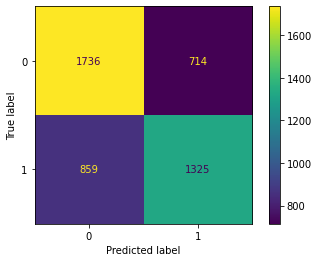

In [24]:
print("TRAIN")
print(f"Accuracy mean: { best_each_classifier['SVC']['estimator']['clf']}")
print(f"Accuracy mean: {best_each_classifier['SVC']['mean_accuracy']}")
print(f"Accuracy std: {best_each_classifier['SVC']['std_accuracy']}")
print(f"AUC mean: {best_each_classifier['SVC']['mean_AUC']}")
print(f"AUC std: {best_each_classifier['SVC']['std_AUC']}")

estimator = best_each_classifier['SVC']['estimator']['clf']
print("TEST")
test_estimator(estimator, X_test, y_test)

Text(0.5, 1.0, 'accuracy')

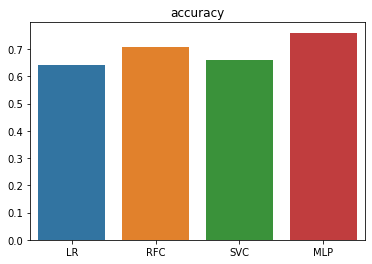

In [25]:
import seaborn as sns
x = ['LR', 'RFC', 'SVC', 'MLP']
y = [0.642, 0.708, 0.661, 0.76]
sns.barplot(x=x, y=y).set_title("accuracy")

Text(0.5, 1.0, 'roc auc score')

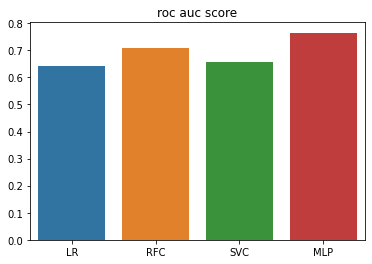

In [26]:
import seaborn as sns
x = ['LR', 'RFC', 'SVC', 'MLP']
y = [0.641, 0.708, 0.658, 0.765]
sns.barplot(x=x, y=y).set_title("roc auc score")